<a href="https://colab.research.google.com/github/ToniYenC11/EmergingTech/blob/main/Programming_Assignment_5_RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CYBERSECURITY ATTACK CLASSIFICATION USING RANDOM FOREST

## Context
You are a cybersecurity intern at SecureNet Corp. The company has been experiencing various network
security breaches, and your team is tasked with developing a machine learning model to classify different
types of cyberattacks.
The senior engineer hands you a dataset of simulated network traffic and says, "We need a robust classifier
to detect attacks like DDoS, Botnet, and others. Use your ML skills to build this. Oh, and don’t forget—
real-world data is messy; make sure your model can handle it."
Your goal is to preprocess the data and train a Random Forest classifier to identify the type of attack.

## Dataset

The dataset cyber_attacks.csv contains the following features:
- protocol_type: Protocol (0: TCP, 1: UDP, 2: ICMP).
- duration: Connection duration (seconds).
- src_bytes: Bytes sent from source.
- dst_bytes: Bytes sent to destination.
- num_packets: Number of packets transmitted.
- num_connections: Number of connections.
- attack_type: Type of attack (Normal, Botnet, DDoS, PortScan, Phishing).

Download the dataset here: [cyber_attacks.csv](https://tupmla-my.sharepoint.com/:x:/g/personal/timothy_amado_tup_edu_ph/EYN4_5H6Y7pLmDe0AwAaXFMBSGPl6sOShjRFrQOajrlGVw?e=0hJChJ).

### General Guidelines
1. Load and perform EDA
2. Perform data preprocessing
3. Train Random Forest Classifier
4. Perform Feature Importance Analysis
5. Evaluate Model Performance and Report Precision, Recall, F-1 Score


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler #Scaling data as one of the vital pre-processing steps

# Load and Perform EDA

In [2]:
data = pd.read_excel('cyber_attacks.xlsx')
display(data.head())
display(data.info())

display(data.groupby('attack_type')['attack_type'].count())

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   protocol_type    10000 non-null  int64  
 1   duration         9500 non-null   float64
 2   src_bytes        9500 non-null   float64
 3   dst_bytes        9500 non-null   float64
 4   num_packets      10000 non-null  int64  
 5   num_connections  10000 non-null  int64  
 6   attack_type      10000 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


None

,attack_type
attack_type,
Botnet,1000
DDoS,1000
Normal,6000
Phishing,1000
PortScan,1000


# Data Preprocessing

- Missing values are found in columns `duration`,`src_bytes`,`dst_bytes`. `attack_type` is not a numerical column.
- The missing values of `duration` are replaced with the median of the respective column through `SimpleImputer`
- The missing values of `src_bytes` and `dst_bytes` are subjected to visualization to understand the distribution of the data. From there, `SimpleImputer` will be used since it is a float type column.
- The `attack_type` column is encoded using `LabelEncoder` to convert the categorical data into numerical data.
- Decision Tree Classifier and Ensemble Approaches do not need **scaling**. As such, no scaling will be done on the dataset.


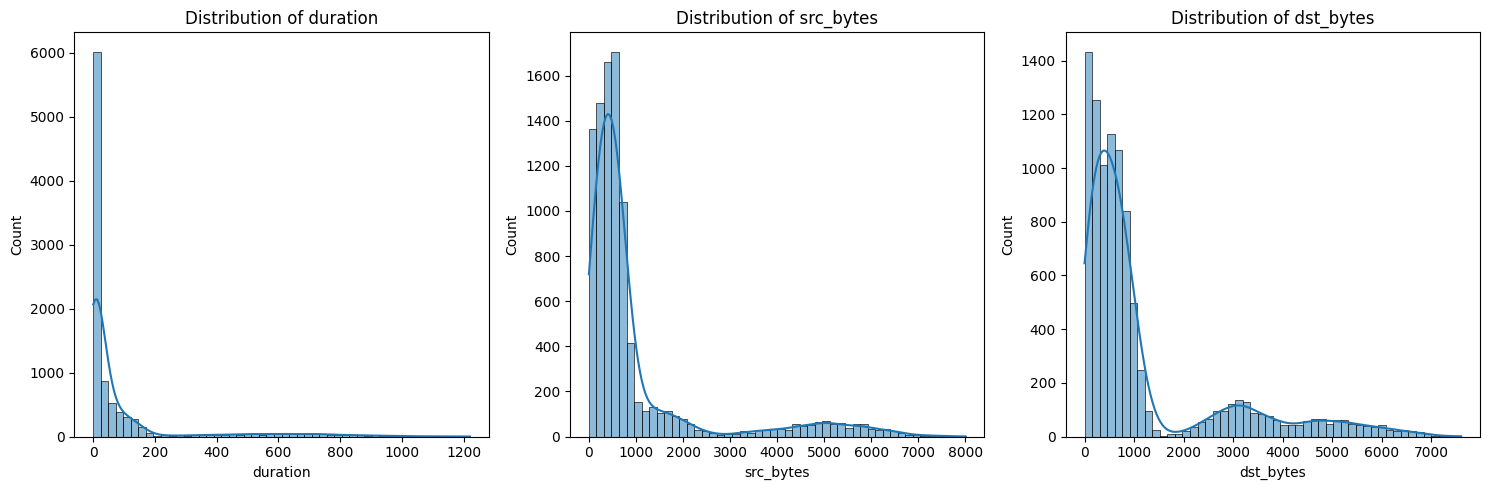

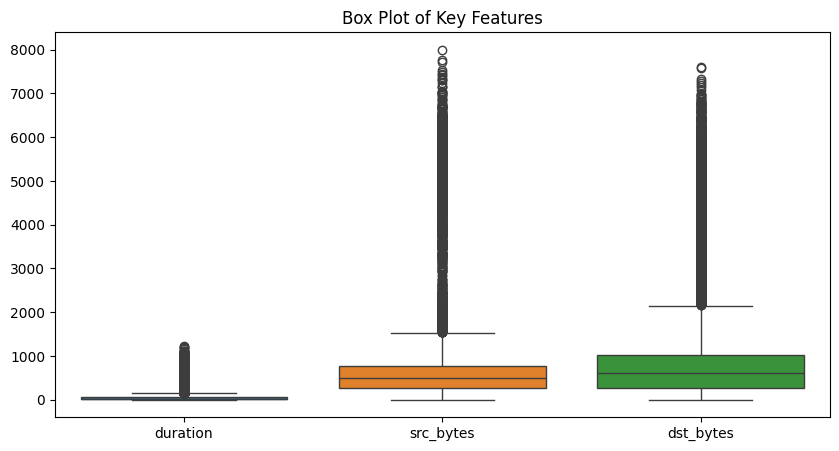

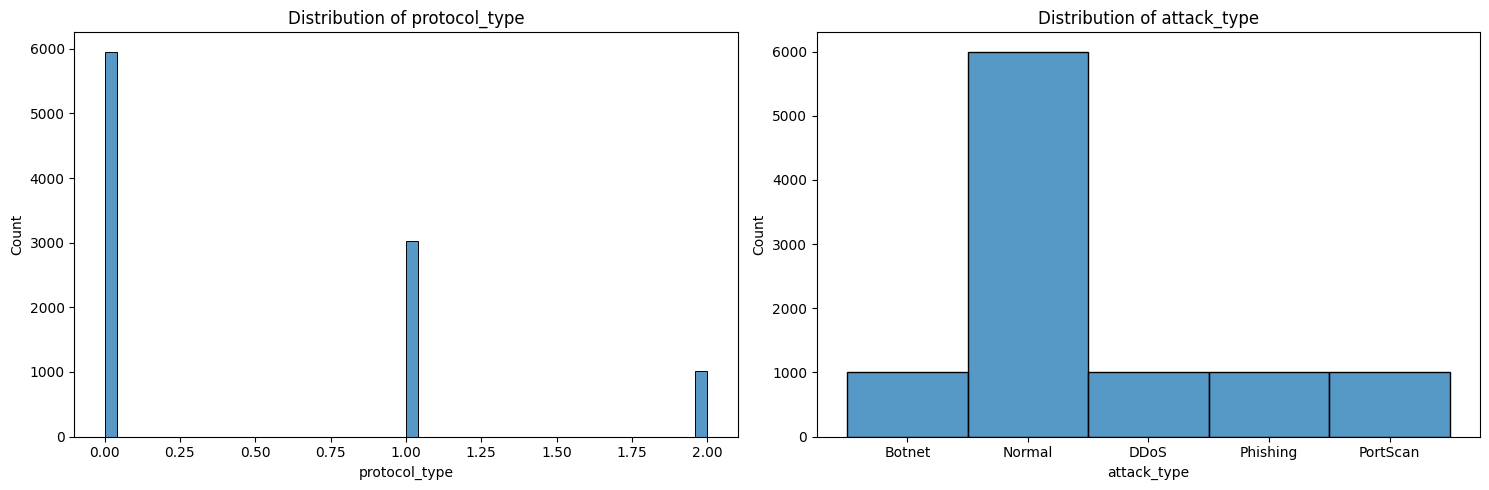

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#* Visualization through histogram
features = ['duration','src_bytes','dst_bytes']
plt.figure(figsize=(15,5))
for i,col in enumerate(features,1):
    plt.subplot(1, len(features), i)
    sns.histplot(data[col], bins=50,kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

#*Detection of outliers using boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['duration', 'src_bytes', 'dst_bytes']])
plt.title('Box Plot of Key Features')
plt.show()

#* Visualization of additional columns: Protocol, attack_type
plt.figure(figsize=(15,5))
for i,col in enumerate(['protocol_type','attack_type'],1):
    plt.subplot(1, 2, i)
    sns.histplot(data[col], bins=50)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

All distributions are skewed to the right, indicating that the majority of the data points are concentrated on the left side of the distribution, and there are a few data points that are much larger than the rest. Thus, for `SimpleImputer`, the strategy is to replace missing values with the median of the respective feature.

Class imbalance occurs on the labels, specifically on the `Normal` attack type which is six times the frequency of all the other types.

**Solution**: We can implement **Oversampling/Undersampling**. The problem with using `KFoldCV` is that the same minority classes will be used as training and test set, leading also to overfitting. While oversampling may also result in overfitting, it can be reduced through the use of random sampling. On the other hand, undersampling will drastically underfit the model on smaller dataset, but the advantage is the model can predict better on the test set.

In this notebook, both are performed without hyperparameter tuning. Only undersampling will be done with hyperparameter tuning

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

#* Label Encoding on the attack_type column
enc = LabelEncoder()
data['attack_type'] = enc.fit_transform(data['attack_type'])
display(data.head())

#* For future purposes, return original labels
#! IMPORTANT: Run the `Load and Perform EDA` every time before running this code block. Failure to do so
#! will return the incorrect label encodings.

label_mapping = {index: class_label for index, class_label in enumerate(enc.classes_)}
print(label_mapping)

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,0
1,1,8.587924,409.971403,710.745376,17,6,2
2,1,4.386891,418.478693,559.457816,17,5,2
3,0,NaN,NaN,NaN,11,3,2
4,0,1.061892,494.253699,572.459614,11,3,2


{0: 'Botnet', 1: 'DDoS', 2: 'Normal', 3: 'Phishing', 4: 'PortScan'}


# Training Model Without Hyperparameter Tuning

## Scenario 1: Oversampling the Minority Classes
- First approach to address class imbalance is to oversample the minority classes. The disadvantage of course is that resampling some of the dataset will result in duplicate datasets, which can overfit the model.

,precision,recall,f1-score,support
0,0.931677,1.000000,0.964630,300.000000
1,1.000000,1.000000,1.000000,300.000000
2,1.000000,0.999444,0.999722,1800.000000
3,1.000000,0.930000,0.963731,300.000000
4,1.000000,1.000000,1.000000,300.000000
accuracy,0.992667,0.992667,0.992667,0.992667
macro avg,0.986335,0.985889,0.985617,3000.000000
weighted avg,0.993168,0.992667,0.992669,3000.000000


Balanced Accuracy Score: 0.9859


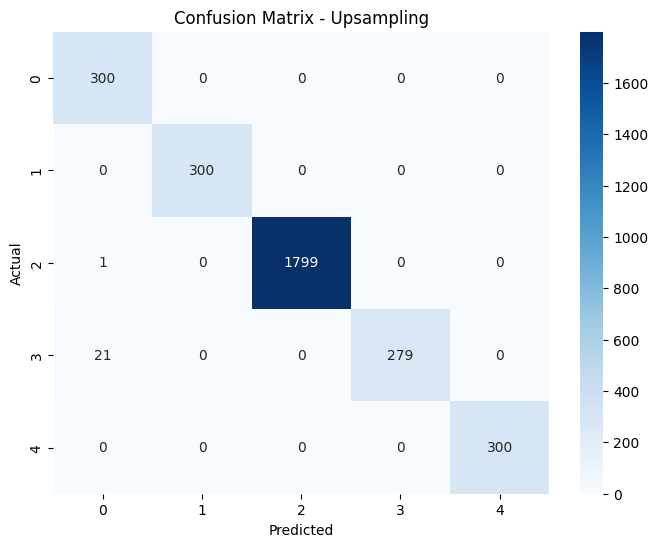

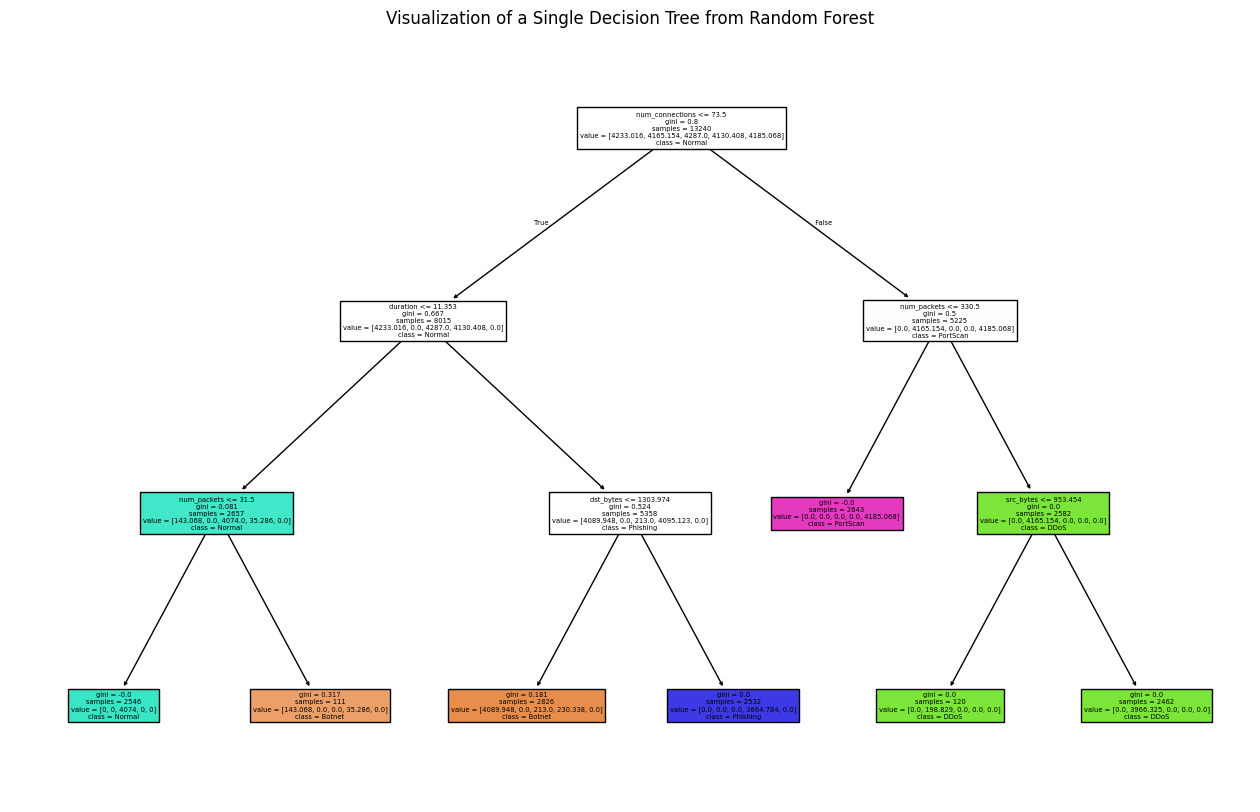

In [ ]:
from sklearn.utils import resample #* For resampling of minority class
X,y = data.drop('attack_type',axis=1) , data['attack_type']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y, random_state=11)

train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['attack_type'] == 2]
minority_classes = train_data[train_data['attack_type'] != 2]

# Oversample the minority classes
minority_upsampled = resample(
    minority_classes,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class)*4,  # Match the number of samples in the majority class
    random_state=11
)

# Combine the upsampled minority classes with the majority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=11).reset_index(drop=True)

# Separate features and labels again
X_train_resampled = balanced_data.drop(columns=['attack_type'])
y_train_resampled = balanced_data['attack_type']

#* Pipeline: Imputation using SimpleImputer on median, then pass to RandomForestClassifier with class_weight='balanced'
clf = make_pipeline(SimpleImputer(strategy='median'),RandomForestClassifier(n_estimators=3,class_weight='balanced',random_state=30,max_depth=3))
clf.fit(X_train_resampled,y_train_resampled)
y_pred = clf.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Upsampling')
plt.show()

#* Visualize one tree
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['randomforestclassifier']
# Step 2: Access the first tree from the RandomForestClassifier
estimator = rf_classifier.estimators_[0]  # Choosing the first tree

# Step 3: Visualize the tree
plt.figure(figsize=(16, 10))
plot_tree(
    decision_tree=estimator,  # Pass the estimator directly
    feature_names=data.columns.drop('attack_type'),  # Feature names
    class_names=list(label_mapping.values()),  # Class names
    filled=True  # Fill nodes with colors
)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

Top 10 Most Important Features:
           Feature  Importance
3        dst_bytes    0.380107
4      num_packets    0.242421
5  num_connections    0.176952
2        src_bytes    0.110332
1         duration    0.090187
0    protocol_type    0.000000


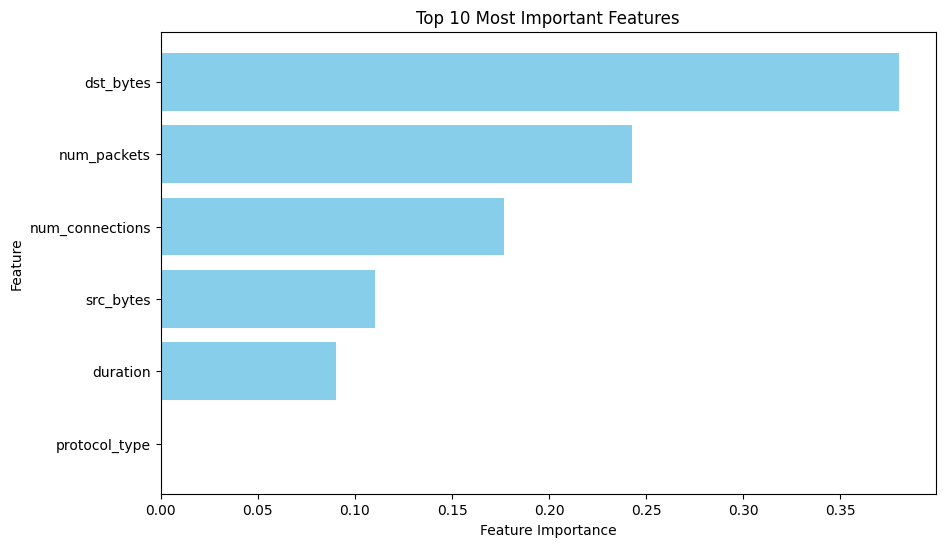

In [ ]:

# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['randomforestclassifier']

# Step 2: Get feature importances
feature_importances = rf_classifier.feature_importances_

# Step 3: Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Step 4: Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

## Scenario 2: Downsampling the Majority Class

The second scenario is therefore, to downsample the majority class instead. This will ensure no duplciate values in all labels.

Class distribution after undersampling:
attack_type
3    700
0    700
4    700
2    700
1    700
Name: count, dtype: int64


,precision,recall,f1-score,support
0,0.993355,0.996667,0.995008,300.000
1,1.000000,1.000000,1.000000,300.000
2,0.999445,1.000000,0.999722,1800.000
3,1.000000,0.993333,0.996656,300.000
4,1.000000,1.000000,1.000000,300.000
accuracy,0.999000,0.999000,0.999000,0.999
macro avg,0.998560,0.998000,0.998277,3000.000
weighted avg,0.999002,0.999000,0.999000,3000.000


Balanced Accuracy Score: 0.9980


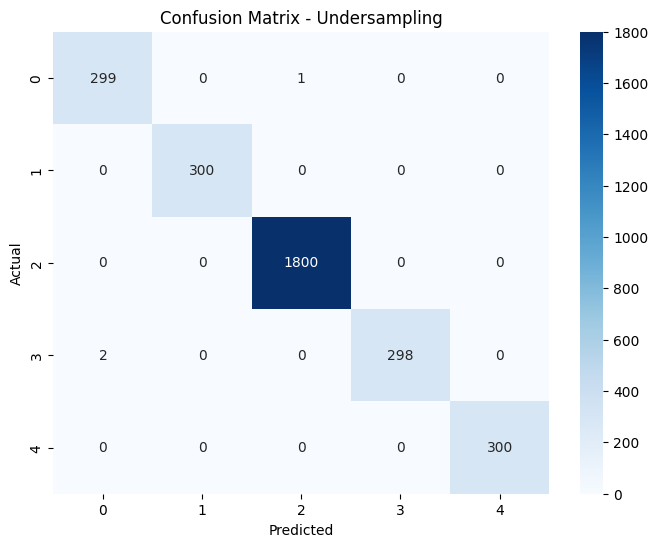

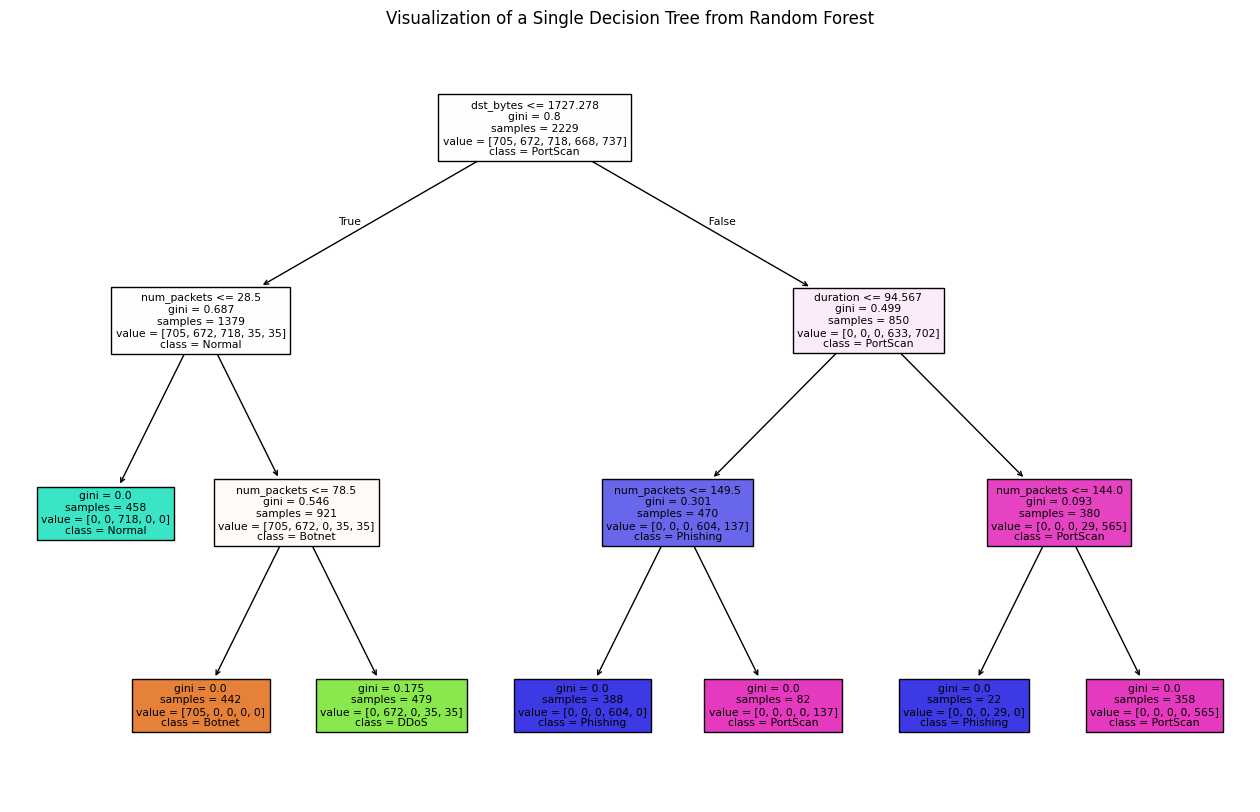

In [ ]:
majority_downsampled = resample(
    majority_class,
    replace=False,  # Sample without replacement
    n_samples=len(minority_classes)//4,  # Match the number of samples in the minority classes
    random_state=42
)

balanced_data = pd.concat([majority_downsampled, minority_classes])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and labels again
X_train_resampled = balanced_data.drop(columns=['attack_type'])
y_train_resampled = balanced_data['attack_type']

# Check the class distribution after resampling
print("Class distribution after undersampling:")
print(y_train_resampled.value_counts())

#* Pipeline: Imputation using SimpleImputer on median, then pass to RandomForestClassifier with class_weight='balanced'
clf = make_pipeline(SimpleImputer(strategy='median'),RandomForestClassifier(class_weight='balanced',random_state=42,max_depth=3))
clf.fit(X_train_resampled,y_train_resampled)
y_pred = clf.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Undersampling')
plt.show()

#* Visualize one tree
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['randomforestclassifier']
# Step 2: Access the first tree from the RandomForestClassifier
estimator = rf_classifier.estimators_[0]  # Choosing the first tree

# Step 3: Visualize the tree
plt.figure(figsize=(16, 10))
plot_tree(
    decision_tree=estimator,  # Pass the estimator directly
    feature_names=data.columns.drop('attack_type'),  # Feature names
    class_names=list(label_mapping.values()),  # Class names
    filled=True  # Fill nodes with colors
)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

Top 10 Most Important Features:
           Feature  Importance
4      num_packets    0.364643
5  num_connections    0.257609
3        dst_bytes    0.148900
1         duration    0.143457
2        src_bytes    0.085381
0    protocol_type    0.000010


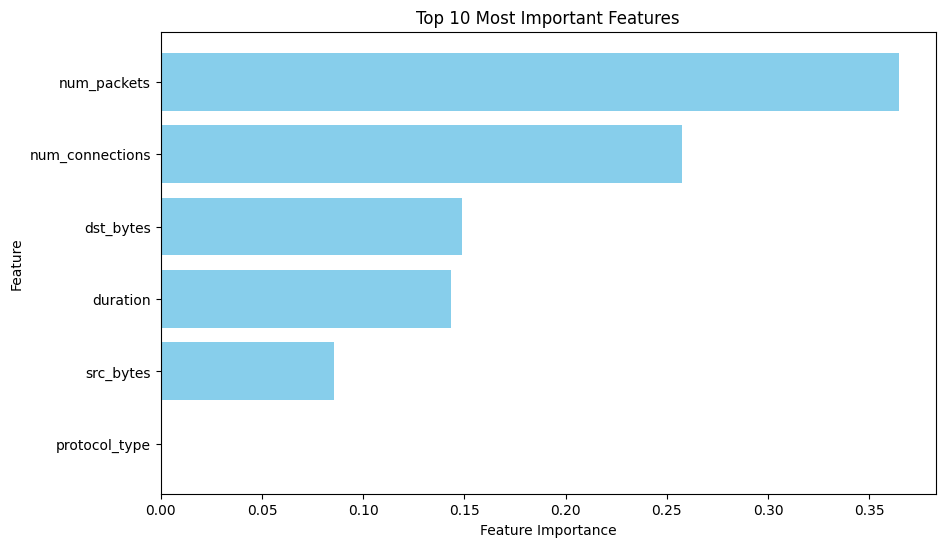

In [ ]:

# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['randomforestclassifier']

# Step 2: Get feature importances
feature_importances = rf_classifier.feature_importances_

# Step 3: Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Step 4: Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

The downside of hyperparameter tuning is when your objective is to find the model that will not overfit on the data, it becomes significantly useless to perform since it will always return the model with a higher accuracy on the dataset, which can be as high as 100%. Thus, some hyperparameters must be controlled.

- `max_depth` represents the maximum number of leaves per tree. When not limited, it can stretch to as high as it can in order to find the 100% fitting model. To prevent this, experimental determinations hwosh that setting it to $3$ has limited the behavior that it reaches a 100%.

# Training Model With Hyperparameter Tuning

Fitting 5 folds for each of 528 candidates, totalling 2640 fits
Best Hyperparameters:
{'classifier__bootstrap': False, 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10}


,precision,recall,f1-score,support
0,0.934375,0.996667,0.964516,300.000000
1,1.000000,1.000000,1.000000,300.000000
2,0.999444,0.999444,0.999444,1800.000000
3,1.000000,0.933333,0.965517,300.000000
4,1.000000,1.000000,1.000000,300.000000
accuracy,0.992667,0.992667,0.992667,0.992667
macro avg,0.986764,0.985889,0.985896,3000.000000
weighted avg,0.993104,0.992667,0.992670,3000.000000


Balanced Accuracy Score: 0.9859


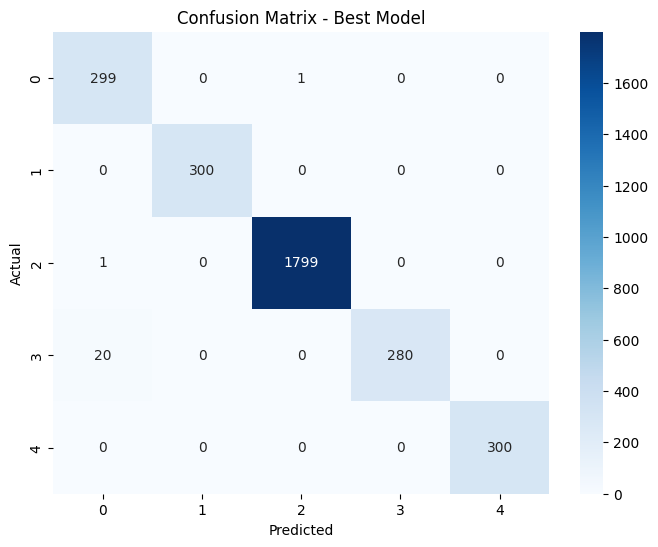

Top 10 Most Important Features:
           Feature  Importance
4      num_packets    0.398821
5  num_connections    0.231276
2        src_bytes    0.166643
3        dst_bytes    0.124298
1         duration    0.078962
0    protocol_type    0.000000


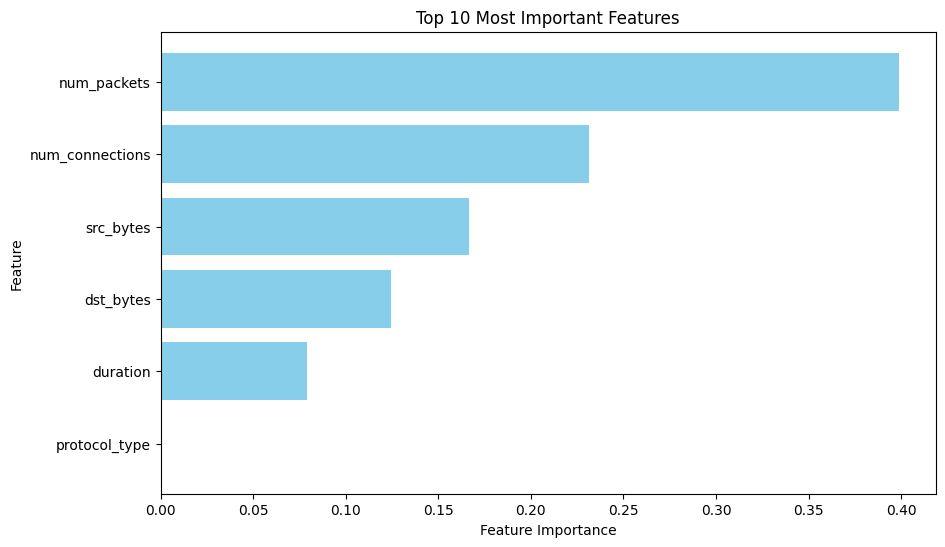

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=10))
])

# Define the hyperparameter grid
param_grid = {
    'classifier__n_estimators': list(range(10,21)),  # Number of trees
    'classifier__max_depth': [3],  # Maximum depth of trees
    'classifier__min_samples_split': list(range(2,6)),  # Minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'classifier__max_features': ['sqrt', 'log2'],  # Number of features to consider for splits
    'classifier__bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced datasets
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()

# Feature Importance Analysis
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = best_model.named_steps['classifier']

# Step 2: Get feature importances
feature_importances = rf_classifier.feature_importances_

# Step 3: Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Step 4: Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

# Training Using the `Imbalance Learn` Library

The `Imbalance Learn` library offers Machine Learning models for imbalanced datasets just like our dataset. The difference with this library and sklearn is that this library gives options regarding the class weights. The `BalancedRandomForestClassifier` of this library will draw a bootstrap sample from the minority class and sample with replacement the same number of samples from the majority class.

,precision,recall,f1-score,support
0,0.967638,0.996667,0.981938,300.000000
1,1.000000,1.000000,1.000000,300.000000
2,0.999445,1.000000,0.999722,1800.000000
3,1.000000,0.966667,0.983051,300.000000
4,1.000000,1.000000,1.000000,300.000000
accuracy,0.996333,0.996333,0.996333,0.996333
macro avg,0.993416,0.992667,0.992942,3000.000000
weighted avg,0.996431,0.996333,0.996332,3000.000000


Balanced Accuracy Score: 0.9927


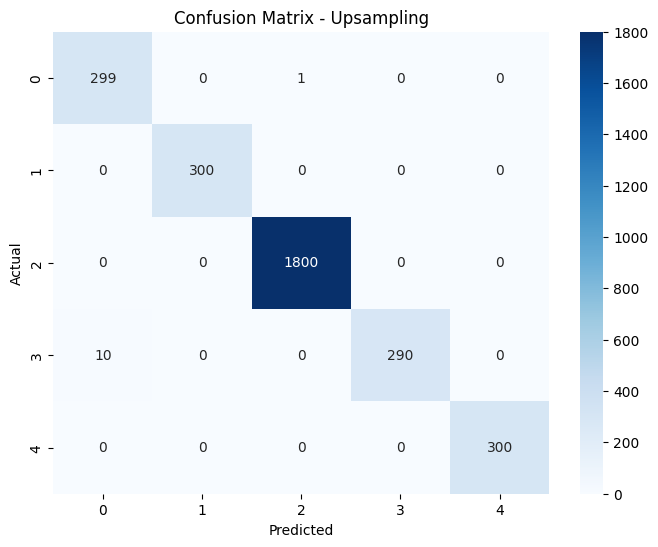

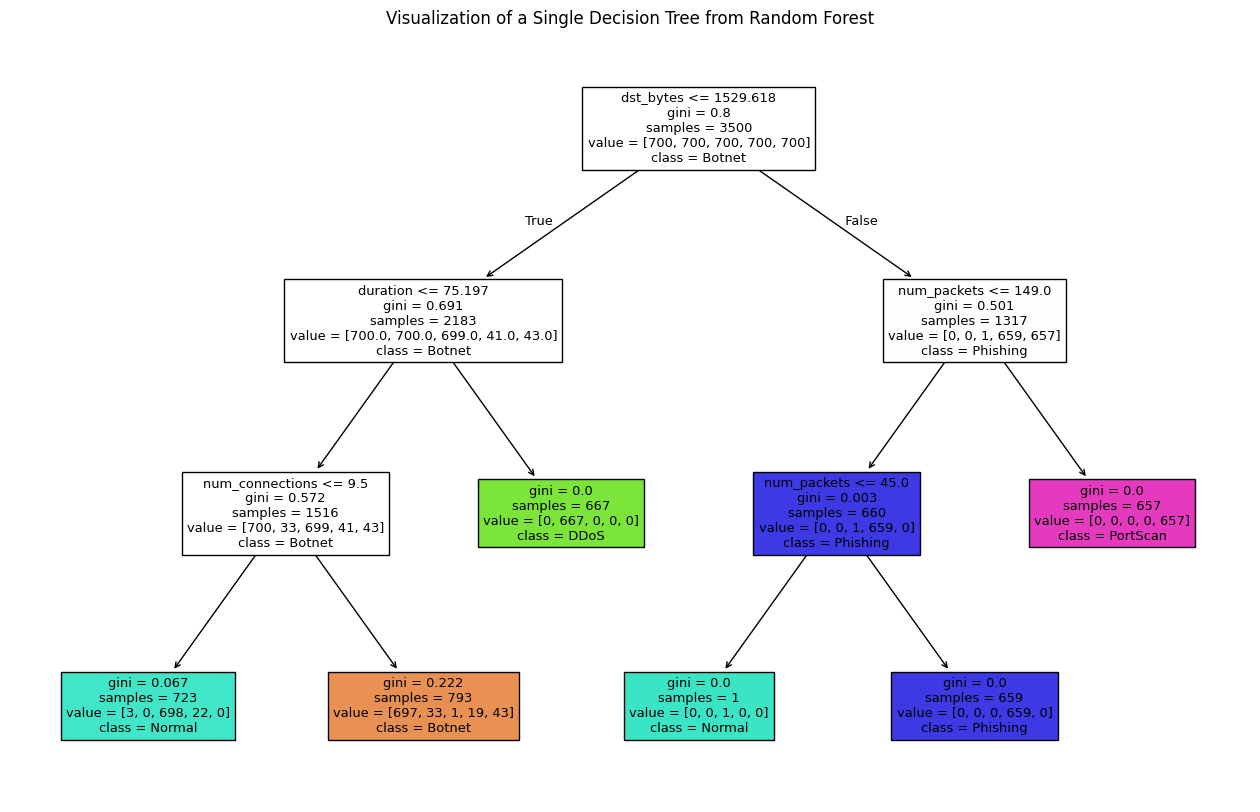

In [ ]:
#X_train and y_train are already defined
from imblearn.ensemble import BalancedRandomForestClassifier
clf = make_pipeline(SimpleImputer(strategy='median'),BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=3, random_state=11,
    bootstrap=False))
# bootstrap - False because replacement = True.
# max_depth - The maximum depth of the tree. Only up to three leaves
clf.fit(X_train,y_train)
#print(clf['balancedrandomforestclassifier'].feature_importances_)
y_pred = clf.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Upsampling')
plt.show()

#* Visualize one tree
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['balancedrandomforestclassifier']
# Step 2: Access the first tree from the RandomForestClassifier
estimator = rf_classifier.estimators_[0]  # Choosing the first tree

# Step 3: Visualize the tree
plt.figure(figsize=(16, 10))
plot_tree(
    decision_tree=estimator,  # Pass the estimator directly
    feature_names=data.columns.drop('attack_type'),  # Feature names
    class_names=list(label_mapping.values()),  # Class names
    filled=True  # Fill nodes with colors
)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

,precision,recall,f1-score,support
0,0.970874,1.000000,0.985222,300.000000
1,1.000000,1.000000,1.000000,300.000000
2,0.997783,1.000000,0.998890,1800.000000
3,1.000000,0.956667,0.977853,300.000000
4,1.000000,1.000000,1.000000,300.000000
accuracy,0.995667,0.995667,0.995667,0.995667
macro avg,0.993731,0.991333,0.992393,3000.000000
weighted avg,0.995757,0.995667,0.995642,3000.000000


Balanced Accuracy Score: 0.9913


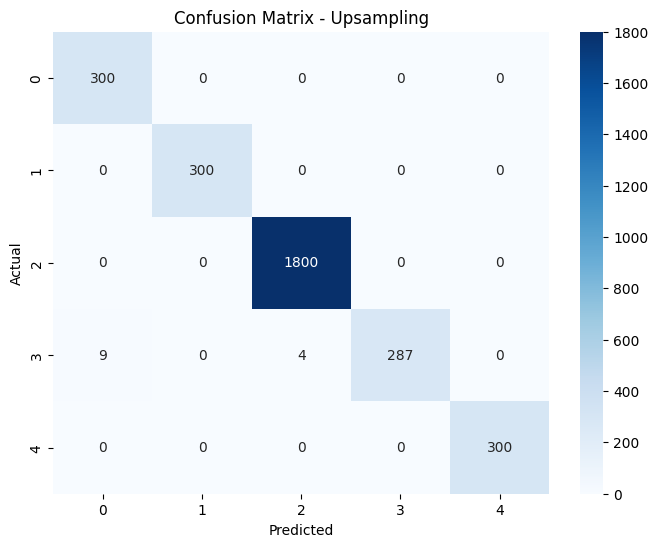

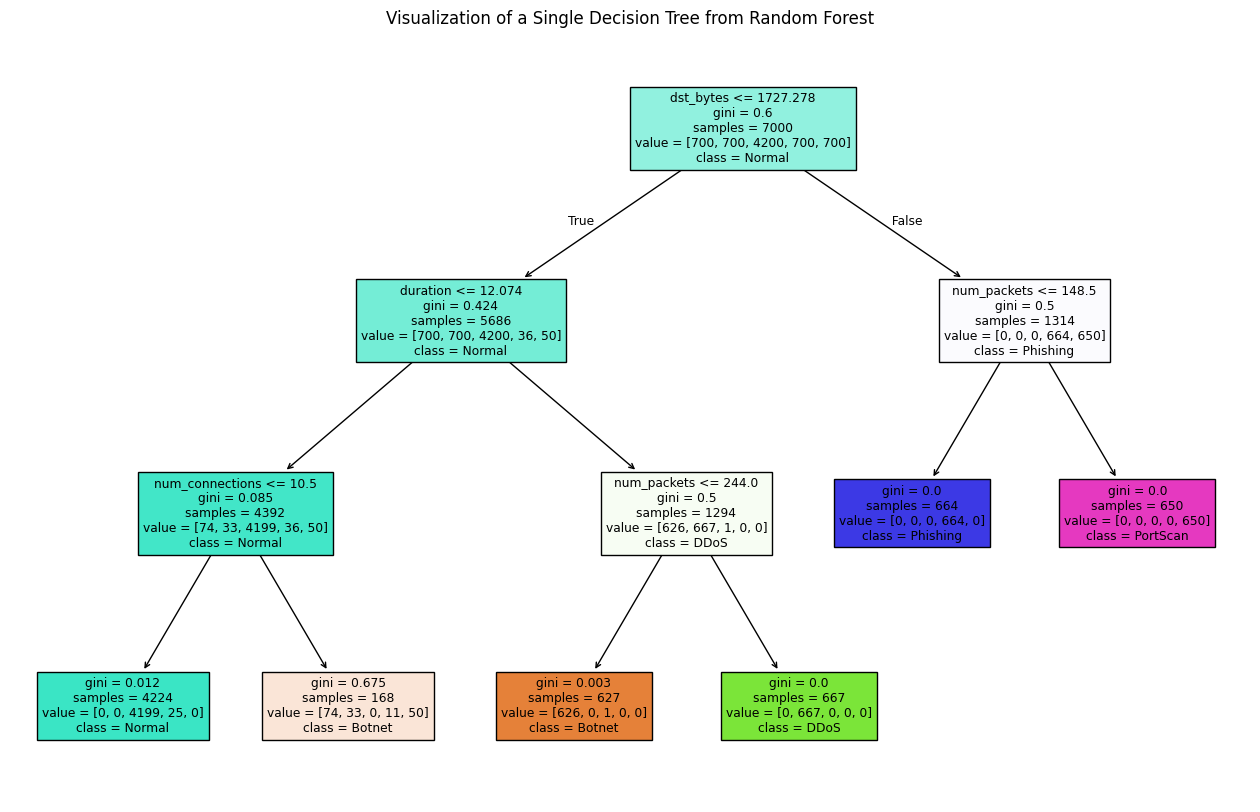

In [ ]:
# Sampling strategy: not majority
#X_train and y_train are already defined

clf_1 = make_pipeline(SimpleImputer(strategy='median'),BalancedRandomForestClassifier(
    sampling_strategy="not majority", replacement=True, max_depth=3, random_state=11,
    bootstrap=False))
# bootstrap - False because replacement = True.
# max_depth - The maximum depth of the tree. Only up to three leaves
clf_1.fit(X_train,y_train)
#print(clf['balancedrandomforestclassifier'].feature_importances_)
y_pred = clf_1.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Upsampling')
plt.show()

#* Visualize one tree
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf_1.named_steps['balancedrandomforestclassifier']
# Step 2: Access the first tree from the RandomForestClassifier
estimator = rf_classifier.estimators_[0]  # Choosing the first tree

# Step 3: Visualize the tree
plt.figure(figsize=(16, 10))
plot_tree(
    decision_tree=estimator,  # Pass the estimator directly
    feature_names=data.columns.drop('attack_type'),  # Feature names
    class_names=list(label_mapping.values()),  # Class names
    filled=True  # Fill nodes with colors
)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

# Guide Questions



1.   Preprocessing
  - How did you handle missing values in numerical features?
  - Why is there a need to encode protocol_type feature, and which encoding method can be used?
2.   Model Training
  - How did you address class imbalance in the dataset?
  - What hyperparameters of the Random Forest did you tune, and why?
  - Why is a pipeline useful for this task?
3. Evaluation
  - Why is accuracy alone insufficient to evaluate this model?
  - Which attack type was hardest to classify, and why might this be?
4. Interpretation
  - Which features were most important for classification? Does this align with real-world attack patterns?
  - How would you explain the model’s decision-making process to a non-technical team?
5. Application
  - What steps would you take to deploy this model in a real-time network monitoring system?
  - How would you handle new attack types not present in the training data?



## Answers

1. Preprocessing
  - Missing numerical values can be handled using `SimpleImputer` from `sklearn.impute`. Due to outliers in the data (as seen in the boxplot), the mean method is not possible and thus, the median method was used.
  - Encoding `protocol_type` converts categorical strings into numerical values for the model. The dataset already handles this, but if not, `OrdinalEncoder` or `pd.get_dummies` can be used. `OrdinalEncoder` maps strings to numbers, while `get_dummies` creates new columns.

2. Model Training
  - Class imbalanced can be solved in three different ways:
    1. **Undersampling** the majority class, which is highly preferrable as it reduces overfitting, a common issue with Random Forest. However, it may lead to underfitting and lower accuracy.
    2. **Oversampling** the minority classes balances the dataset by increasing their sample size. While this can still cause overfitting, it does so in a non-deterministic way since sampling occurs without replacement.
    3. Using a **Balanced Random Forest Classifier** from `imblearn`. It differs from the standard model by drawing a `bootstrap` sample from the minority class and sample with replacement the same number of samples from the majority class.
  
    **Bootstrapping** is a resampling technique where you create multiple datasets by randomly sampling with replacement from the original dataset, used to estimate the quality of a model and reduce overfitting.

  - Tuning was performed on `n_estimators`, `min_samples_split`, `min_samples_leaf`, `max_features`, and `bootstrap`, not to maximize accuracy (which would reach 100%) but to find a better-performing model when these parameters are clipped to lower values. For example, `max_depth` is limited to $3$ to prevent more leaves from increasing the accuracy that will reach a 100%.The chosen values are intentionally lower than defaults because the default values always results in a 100% accuracy (overfitted).
  - A pipeline is useful for reusability across different model modifications. In this experiment, it was used to apply imputation before passing the data to the Random Forest classifier. It was also used extensively in the hyperparameter tuning to systematically tune the model's parameters.

3. Evaluation
  - Class imbalance skews accuracy toward the dominant class, leading to misleading results. The use of precision and recall ensures that the model is evaluated based on correct predictions for each class. The F-1 score is an all-in-one metric for precision and recall. For more info,
  - **Precision**: Measures the proportion of correctly predicted instances among all instances predicted as a specific class.
  - **Recall**: Measures the proportion of correctly predicted instances among all actual instances of a specific class.
  - **F1-score**: The harmonic mean of precision and recall, providing a balanced view of a model's performance.

4. Interpretation
  - The most interesting, as well as important, feature is the number of packets and source duration since it can indicate that an attack happened in the logs. It's one of the key evidence in the network infrastructure. Second, the number connection, this can indicate that an DOS or DDOS happened.
  - Think of the model like choosing a movie with the help of multiple friends. Each friend has a different approach—one focuses on actors, another on genre, and another on reviews. Instead of relying on just one, you consider all their opinions and go with the majority vote.

5. Application
  - Steps to take in deploying the model in real-time network monitoring system:
    - The first step is to retrain the model with added parameters to check if the model can retains it's consistency and reliability in detecting cyberattacks. As network threats been growing in this modern age with AIAs network threats evolve, especially with the rise of AI-driven attacks, the model should be continuously updated and scalable to adapt to emerging threats in real-world network environments.
    - For real-time detection, network traffic data needs to be captured using tools like Wireshark, Zeek (Bro), or Suricata. The system should extract relevant features such as protocol type, duration, src_bytes, dst_bytes, num_packets, and num_connections to feed into the model. It is essential to apply the same preprocessing techniques used during training, such as handling missing values and encoding categorical data, to maintain consistency in predictions.
    - Since network monitoring requires real-time decision-making, the model should be optimized for speed. The trained Random Forest model can be converted into a more efficient format like ONNX, TensorFlow Lite, or Joblib for faster inference. Techniques such as feature selection, pruning, and quantization can help reduce computational overhead. Deploying the model on optimized hardware such as GPUs, FPGAs, or edge devices will further enhance its speed and scalability.
    - To enhance security operations, the model should be integrated with SIEM tools like Splunk, IBM QRadar, or Elastic Security. This integration enables the system to log events, generate alerts, and automate responses. For example, if the model detects a DDoS attack, the SIEM system can automatically trigger IP blocking or send alerts to the security team for further investigation.

  - Handling new attack types not present in the training data requires implementing robust anomaly and outlier detection mechanisms alongside the existing supervised model. One approach is to integrate unsupervised or semi-supervised learning techniques that continuously monitor network behavior and flag unusual patterns for further investigation. This might include clustering methods or autoencoders that learn the normal behavior of network traffic and trigger alerts when deviations occur. Additionally, employing ensemble methods that combine traditional signature-based detection with behavior-based anomaly detection can improve the overall system's sensitivity to novel threats.